In [1]:
import pathlib
import numpy as np
from fytok.Tokamak import Tokamak
from fytok.modules.Equilibrium import Equilibrium
from fytok.utils.logger import logger
from spdm.view.View import display
from spdm.data.File import File
from spdm.data.Path import Path
from spdm.data.Entry import Entry
from spdm.view import View as sp_view

WORKSPACE = "/home/salmon/workspace"  # "/ssd01/salmon_work/workspace/"
output_path = pathlib.Path(f"{WORKSPACE}/output/")

2023-12-14 13:00:28,835 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2023-12-14T13:00:28.580136.
 Job ID: fytok_salmon_surface_26608

###################################################################################################



In [2]:
input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")
# equilibrium = Equilibrium(f"file+GEQdsk://{WORKSPACE}/gacode/neo/tools/input/profile_data/g141459.03890#equilibrium")
tok = Tokamak(
    # "file+geqdsk:///home/salmon/workspace/fytok_data/data/g070754.05000",
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="east",
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.0, 0.999, 128)}}},
)

2023-12-14 13:00:29,019 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2023-12-14 13:00:29,197 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2023-12-14 13:00:29,251 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


2023-12-14 13:00:29,317 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2023-12-14 13:00:29,571 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2023-12-14 13:00:29,575 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2023-12-14 13:00:29,580 [    spdm]     INFO: Initialize module fytok.modules.TF 
2023-12-14 13:00:29,584 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2023-12-14 13:00:29,587 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2023-12-14 13:00:29,592 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2023-12-14 13:00:30,338 [    spdm]     INFO: Load module spdm.view.view_matplotlib


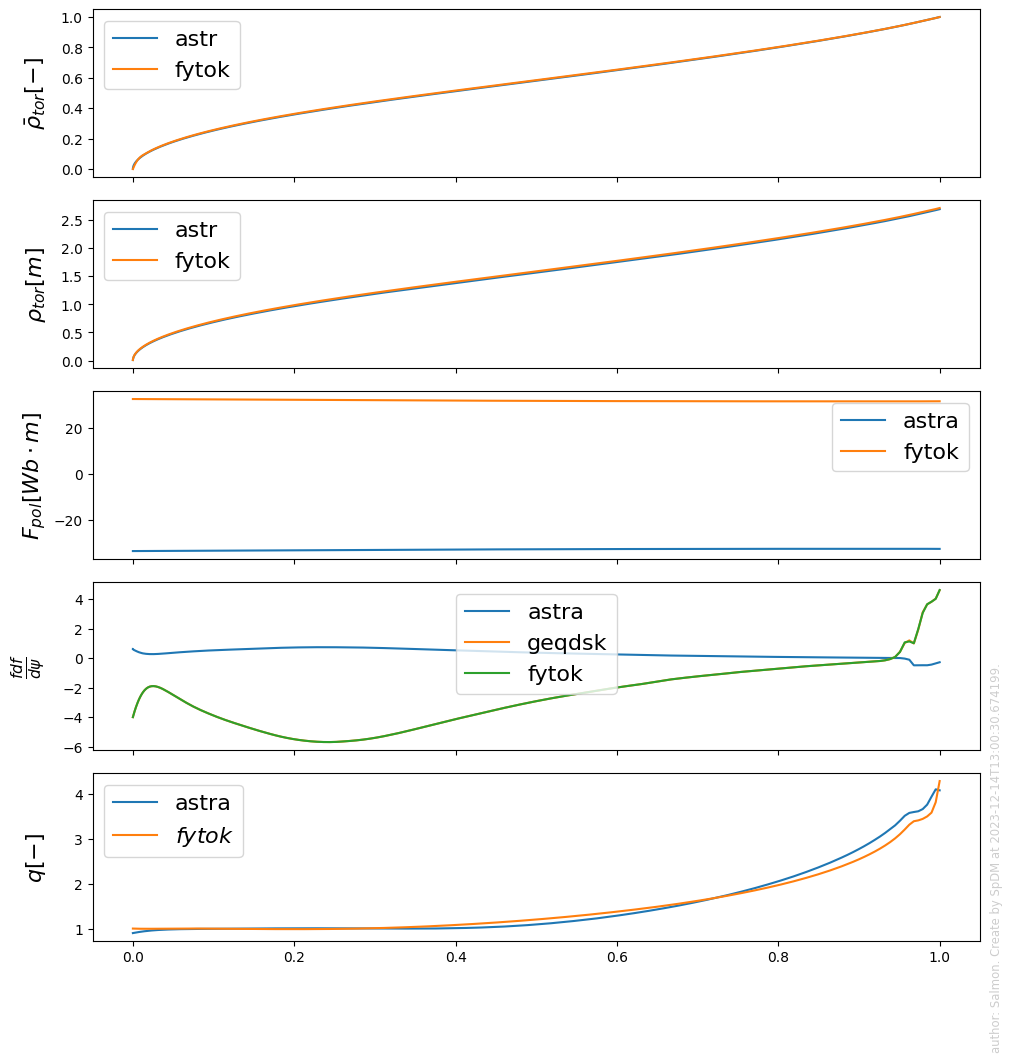

In [3]:
from spdm.data.Function import Function

eqdsk_file = File(f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}").entry
psi_axis = eqdsk_file.get("equilibrium/time_slice/0/global_quantities/psi_axis")
psi_boundary = eqdsk_file.get("equilibrium/time_slice/0/global_quantities/psi_boundary")
bs_eq_psi = eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/psi")
bs_eq_psi_norm = (bs_eq_psi - psi_axis) / (psi_boundary - psi_axis)
bs_eq_fpol = Function(bs_eq_psi_norm, eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f"))

fig = sp_view.plot(
    tok.core_profiles.time_slice.current.profiles_1d.grid.psi_norm,
    (
        [
            (tok.core_profiles.time_slice.current.profiles_1d.grid.rho_tor_norm, "astr"),
            (
                Function(
                    tok.equilibrium.time_slice.current.profiles_1d.grid.psi_norm,
                    tok.equilibrium.time_slice.current.profiles_1d.grid.rho_tor_norm,
                ),
                "fytok",
            ),
        ],
        {"y_label": r"$\bar{\rho}_{tor}[-]$"},
    ),
    (
        [
            (tok.core_profiles.time_slice.current.profiles_1d["rho_tor"], "astr"),
            (tok.equilibrium.time_slice.current.profiles_1d.rho_tor, "fytok"),
        ],
        {"y_label": r"$\rho_{tor}[m]$"},
    ),
    (
        [
            (bs_eq_fpol, "astra"),
            (tok.equilibrium.time_slice.current.profiles_1d.f, r"fytok"),
        ],
        {"y_label": r"$F_{pol} [Wb\cdot m]$"},
    ),
    (
        [
            (tok.core_profiles.time_slice.current.profiles_1d.cache_get("ffprime"), "astra"),
            (Function(bs_eq_psi_norm, eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f_df_dpsi")), "geqdsk"),
            (tok.equilibrium.time_slice.current.profiles_1d.f_df_dpsi, r"fytok"),
        ],
        {"y_label": r"$\frac{f df}{d\psi} $"},
    ),
    (
        [
            (
                Function(
                    tok.core_profiles.time_slice.current.profiles_1d.grid.psi_norm,
                    tok.core_profiles.time_slice.current.profiles_1d["q"],
                ),
                r"astra",
            ),
            (tok.equilibrium.time_slice.current.profiles_1d.q, {"label": r"$fytok$"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    # (
    #     [
    #         (
    #             function_like(4 * (scipy.constants.pi**2) * R0 * profiles["rho"].values, bs_psi),
    #             {"label": r"$4\pi^2 R_0 \rho$", **bs_line_style},
    #         ),
    #         (
    #             eq_profiles_1d.dvolume_drho_tor,
    #             {
    #                 "label": r"$dV/d\rho_{tor}$",
    #             },
    #         ),
    #     ],
    #     {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"},
    # ),
)

/home/salmon/workspace/fytok/SpDM/python/spdm/data/Expression.py:487: RuntimeWarning: divide by zero encountered in divide
  value = func(*args, **kwargs)


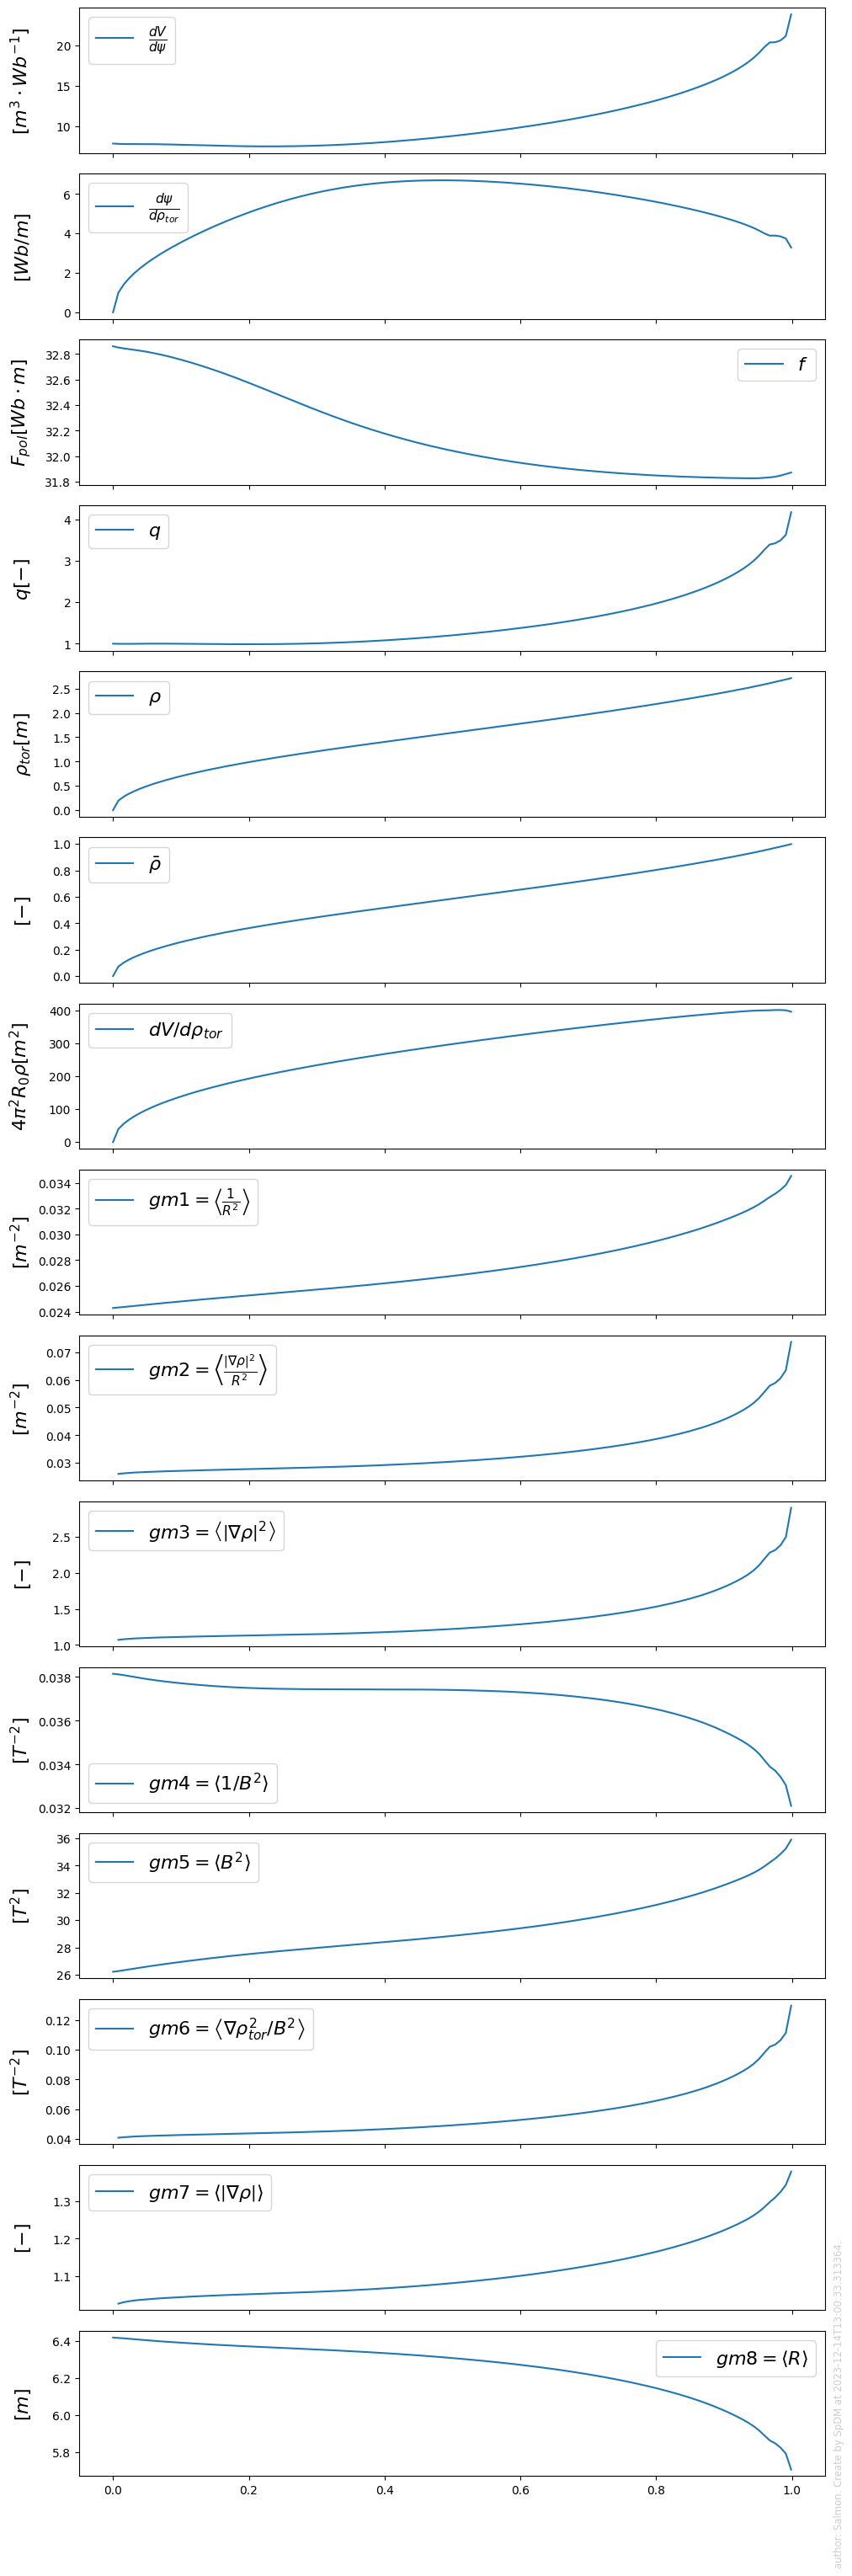

In [4]:
eq_profiles_1d = tok.equilibrium.time_slice.current.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm,
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    ((eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"), {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"}),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
)